# 16: Code Challenge - The Impact of Batch Size

### 🎯 Objective
In this challenge, we perform a hyperparameter sweep on the **Batch Size**. Using the Wine Quality dataset, we will observe how changing the batch size affects both the **accuracy** of the model and the **computation time** required to train it.

### 📚 Key Concepts
- **Small Batches:** Noisier gradient estimates (more fluctuation), more updates per epoch. Can help escape local minima but slower computationally.
- **Large Batches:** Smoother gradient estimates, fewer updates per epoch. Faster computationally (vectorization) but might converge to sharp minimas (less generalization).
- **Computation Time:** Measuring 'wall clock' time to see the efficiency benefits of parallel processing with larger batches.

In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import scipy.stats as stats
import pandas as pd
import time
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipython-input-273002196.py:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


## 1. Data Processing

We repeat the cleaning and preprocessing steps from the previous lesson:
1.  Load Data.
2.  Remove Outliers (Total Sulfur Dioxide > 200).
3.  Z-Score Normalize features.
4.  Binarize Quality (Target).

In [3]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')

# remove outliers
data = data[data['total sulfur dioxide']<200]

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
data['boolQuality'][data['quality']>5] = 1

/tmp/ipython-input-1552339086.py:15: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['boolQuality'][data['quality']>5] = 1
/tmp/ipython-input-1552339086.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

## 2. Prepare Tensors
Convert to PyTorch tensors and create the `TensorDataset` objects. We do **not** create the DataLoaders here because the `batch_size` will change inside our experiment loop.

In [4]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()
labels = labels[:,None] # transform to matrix (N, 1)

# split data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# make tensor datasets
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)

## 3. Define the Model

We define a class `ANNwine` for our model structure. This is slightly cleaner than `nn.Sequential` when we might want to add custom logic in `forward`, though `nn.Sequential` would also work fine here.

**Architecture:**
Input (11) -> 16 -> 32 -> 32 -> Output (1)

In [5]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)

    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)

  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) ) # fully connected
    x = F.relu( self.fc2(x) )
    return self.output(x)

## 4. Train Function

We create a reusable training function. Note that it relies on a global object `train_loader`, which we will overwrite in each iteration of our experiment.

In [6]:
# a function that trains the model

# global parameter
numepochs = 1000

def trainTheModel():

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    winenet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd (saves memory/speed)
      yHat = winenet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )

  # function output
  return trainAcc,testAcc,losses

## 5. The Experiment: Loop over Batch Sizes

We iterate through powers of 2 for batch sizes: $2^1$ to $2^9$. 

**Crucial Step:** Inside the loop, we re-initialize `winenet = ANNwine()`. If we didn't do this, we would be training the *same* model over and over, and the later batch sizes would look artificially good because they started with pre-trained weights.

In [7]:
# This cell takes ~15 mins

# range of batch sizes: 2**1, 2**3, ... 2**9 (2, 8, 32, 128, 512)
batchsizes = 2**np.arange(1,10,2)

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs,len(batchsizes)))
accuracyResultsTest  = np.zeros((numepochs,len(batchsizes)))
comptime             = np.zeros(len(batchsizes))

# test data doesn't vary by training batch size, so we create one loader
test_loader = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

# loop over batch sizes
for bi in range(len(batchsizes)):

  # start the clock!
  starttime = time.process_time()

  # create dataloader object
  # We must recreate this for each new batch size
  train_loader = DataLoader(train_dataDataset,
                          batch_size=int(batchsizes[bi]), shuffle=True, drop_last=True)

  # create and train a model
  winenet = ANNwine()
  trainAcc,testAcc,losses = trainTheModel()

  # store data
  accuracyResultsTrain[:,bi] = trainAcc
  accuracyResultsTest[:,bi]  = testAcc

  # check the timer
  comptime[bi] = time.process_time() - starttime


## 6. Visualize Results

1.  **Line Plot:** Shows the Test Accuracy over epochs for each batch size.
2.  **Bar Plot:** Shows the Total Computation Time for each batch size.

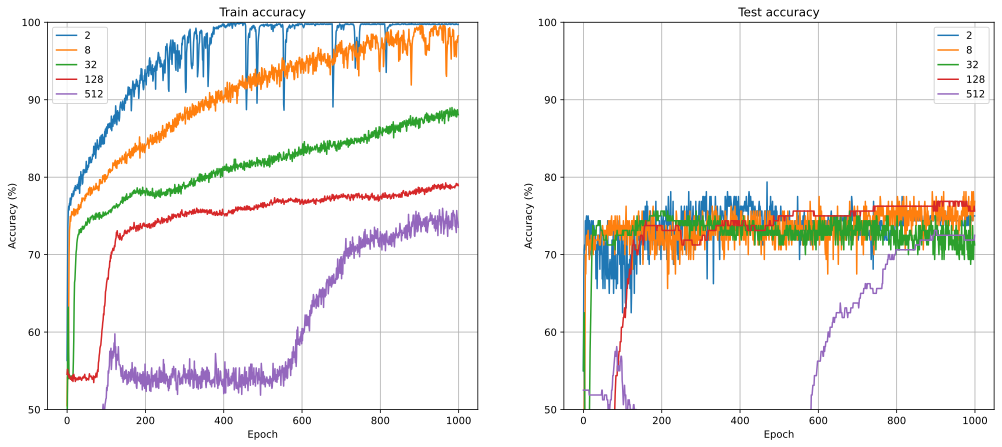

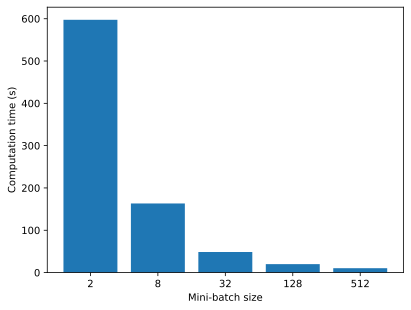

In [8]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

# common features
for i in range(2):
  ax[i].legend(batchsizes)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,100])
  ax[i].grid()

plt.show()



# bar plot of computation time
plt.bar(range(len(comptime)),comptime,tick_label=batchsizes)
plt.xlabel('Mini-batch size')
plt.ylabel('Computation time (s)')
plt.show()